In [4]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [6]:
DIRECTORY = r"C:\Users\souru\OneDrive\Desktop\Face Mask Detection"
CATEGORIES = ["with_mask", "without_mask"]

In [7]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

[INFO] loading images...


In [8]:
# Assuming CATEGORIES is a list of class labels and DIRECTORY is the main dataset directory
for category in CATEGORIES:
    # Create the full path to the category directory
    path = os.path.join(DIRECTORY, category)
    
    # Loop through each image in the category directory
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        
        # Load the image and preprocess it
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        # Append the processed image and its label to the respective lists
        data.append(image)
        labels.append(category)


c:\Users\souru\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [19]:
#check

# Count the number of samples per class
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)


Class Distribution: {'with_mask': 3725, 'without_mask': 3828}


In [20]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [21]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [22]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


C:\Users\souru\AppData\Local\Temp\ipykernel_16260\1868517371.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [24]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [25]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [29]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [30]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...


c:\Users\souru\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


c:\Users\souru\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 195s 997ms/step - accuracy: 0.8253 - loss: 0.4398 - val_accuracy: 0.9696 - val_loss: 0.0943
Epoch 2/20


c:\Users\souru\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.9688 - loss: 0.1223 - val_accuracy: 0.9696 - val_loss: 0.0937
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9692 - loss: 0.1052 - val_accuracy: 0.9828 - val_loss: 0.0574
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step - accuracy: 1.0000 - loss: 0.0649 - val_accuracy: 0.9828 - val_loss: 0.0574
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.9826 - loss: 0.0685 - val_accuracy: 0.9841 - val_loss: 0.0479
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - accuracy: 0.9688 - loss: 0.0752 - val_accuracy: 0.9841 - val_loss: 0.0476
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9808 - loss: 0.0574 - val_accuracy: 0.9848 - val_loss: 0.0437
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.9848 - val_loss: 0.0438
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.9839 - loss: 0.0499 - val_accurac

In [3]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


NameError: name 'model' is not defined

In [2]:

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


NameError: name 'np' is not defined

In [34]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.h5")


[INFO] saving mask detector model...


In [36]:
# serialize the model to disk using the native Keras format
print("[INFO] saving mask detector model in Keras format...")
model.save("mask_detector.keras")


[INFO] saving mask detector model in Keras format...


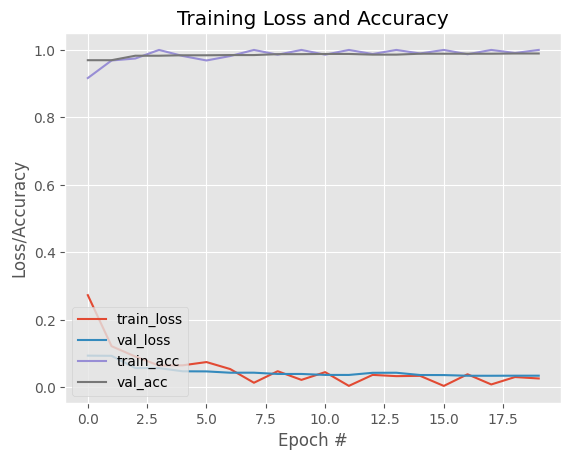

In [35]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")